In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt

# --- TẠO DATA GIẢ LẬP (Mô phỏng dữ liệu thương mại điện tử) ---
# Tạo 500 dòng dữ liệu giao dịch
np.random.seed(42)
n_samples = 500

data = {
    'CustomerID': np.random.randint(1000, 1050, n_samples), # 50 khách hàng
    'InvoiceDate': pd.to_datetime('2024-01-01') + pd.to_timedelta(np.random.randint(0, 365, n_samples), unit='D'),
    'Quantity': np.random.randint(1, 20, n_samples),
    'UnitPrice': np.random.randint(10, 100, n_samples)
}

df = pd.DataFrame(data)

# Tính tổng tiền cho mỗi đơn (TotalAmount)
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

print("Dữ liệu gốc (5 dòng đầu):")
display(df.head())

Dữ liệu gốc (5 dòng đầu):


,CustomerID,InvoiceDate,Quantity,UnitPrice,TotalAmount
0,1038,2024-12-06,15,96,1440
1,1028,2024-02-08,11,58,638
2,1014,2024-04-09,8,18,144
3,1042,2024-10-15,19,29,551
4,1007,2024-09-10,13,70,910


In [2]:
# Chọn mốc thời gian hiện tại (giả định là ngày sau ngày cuối cùng trong data 1 ngày)
current_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group theo CustomerID để tính R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days, # Recency: Số ngày trôi qua
    'CustomerID': 'count',                                  # Frequency: Số lần mua
    'TotalAmount': 'sum'                                    # Monetary: Tổng tiền đã chi
})

# Đổi tên cột
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'CustomerID': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

print("Dữ liệu RFM:")
display(rfm.head())

Dữ liệu RFM:


,Recency,Frequency,Monetary
CustomerID,,,
1000,1,12,6591
1001,9,14,7778
1002,8,12,6732
1003,2,8,5449
1004,44,9,5189


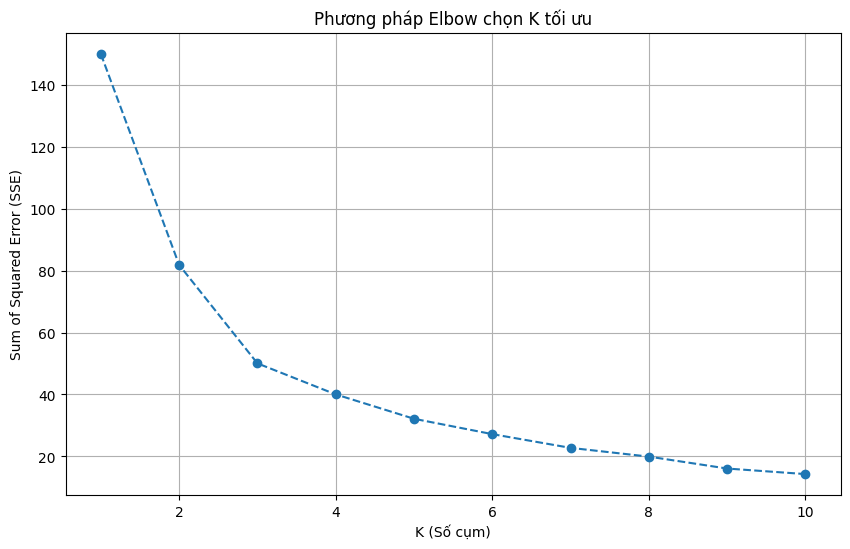

In [3]:
# 1. Chuẩn hóa dữ liệu (Scaling)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# 2. Vẽ biểu đồ Elbow để tìm số cụm (Cluster)
sse = []
k_rng = range(1, 11)

for k in k_rng:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_rng, sse, marker='o', linestyle='--')
plt.xlabel('K (Số cụm)')
plt.ylabel('Sum of Squared Error (SSE)')
plt.title('Phương pháp Elbow chọn K tối ưu')
plt.grid()
plt.show()

# --> Mẹo: Nhìn biểu đồ, chỗ nào gập khúc mạnh nhất thì chọn K đó (thường là 3 hoặc 4)

--- TỔNG HỢP ĐẶC ĐIỂM TỪNG NHÓM ---


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,25.739130,7.956522,3649.913043,23
1,136.750000,4.500000,2396.250000,4
2,34.043478,13.000000,7211.130435,23


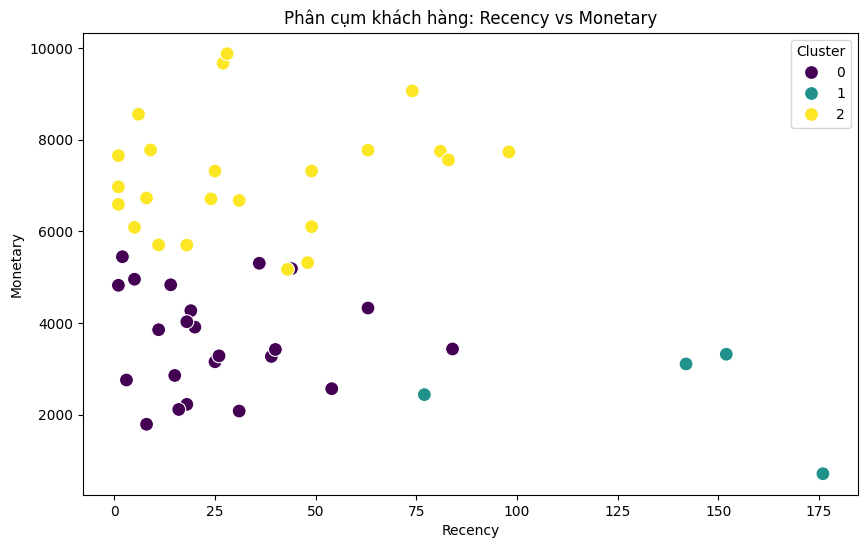

In [4]:
# 1. Train model với K=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)

# 2. Gán nhãn nhóm vào dữ liệu RFM gốc
rfm['Cluster'] = kmeans.labels_

# 3. Phân tích đặc điểm từng nhóm (Insight quan trọng để ghi vào CV)
rfm_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' # Đếm số lượng khách trong mỗi nhóm
}).rename(columns={'Cluster': 'Count'})

print("--- TỔNG HỢP ĐẶC ĐIỂM TỪNG NHÓM ---")
display(rfm_summary)

# 4. Trực quan hóa các nhóm (Scatter Plot)
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis', s=100)
plt.title('Phân cụm khách hàng: Recency vs Monetary')
plt.show()